In [ ]:
# Imports & readDataSubset()
import pandas as pd
import numpy as np
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# # Load fonts
# font_path = r"C:"
# fm.fontManager.addfont(font_path)
# plt.rcParams['font.family'] = 'Helvetica'

# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

In [55]:
"""ResultProbs.ipynb
Get all contests at 1st & results
    Using contest_catch_results.csv (from CatchResults.ipynb)
Get throw characteristics (ball_plane_run.csv)
    Using ball_pos
    Using throw_infos.csv (from ArmStrength.ipynb)
    Define target plane
        Define catchable region sphere
        Then define a 2D plane tangent to that circle,
            perpendicular to the straight line from
            player to base
    Get location & flight characteristics of the ball 
        (At it's intersection with the target plane)
    Get ft_til_1st at intersection
        Using running_smooth.csv (from Running.ipynb)
Get p(contest_results|throw,running) (catch_probability_model)
    ('throw' includes plane orientation)
    Get p(catch_results|throw,ft1_at_itsx)
    If Catch,
        Get p(catch_location|throw,ft1_at_itsx)
        Get Pr(CatchOn|catch_location,throw,ft1_at_itsx)
        If CatchOn,
            Get E[catch_time|catch_location] (catch_timestamp_models)
    Else,
        (Safe/Out/Advance) 
Get Pr(Safe|CatchOff) (safe_probability_catchoff_model)
    (Logistic regression just CatchResults.ipynb)

1. Calculate Pr(Safe|CatchOff) 
    (Logistic regression just CatchResults.ipynb)
2. Filter play_id's for contests at 1st base
    (And get all the data from Contests.ipynb)
    Using contest_catch_results.csv (from CatchResults.ipynb)
3. Define target plane
    Using throw_infos.csv (from ArmStrength.ipynb)
4. Get location & flight characteristics of the ball 
    (At it's intersection with the target plane)
5. Get ft_til_1st at intersection
    Using running_smooth.csv (from Running.ipynb)
6. Prepare dataset for machine learning modeling
    (Get expected time between intersection & catch)
    (Feature engineering)
    Using everything above
X. (Export)
6. Fit ML model for catch result classification
7. Create & evaluate the ensemble
8. Fit ML model for catch timestamp at intersection
    (Filter for catches)   

"""
pass

In [56]:
"""
Filter play_id's for contests at 1st base
    (And get all the data from Contests.ipynb)
    Using contest_catch_results.csv (from CatchResults.ipynb)
"""
contest_catch_results = pd.read_csv("../CSV/contest_catch_results.csv")
contest_catch_results.head(5)

,game_str,play_id,safe,advanced,thr_ts,acq_ts,arr_ts,target_base,nth_throw,ft_til_1st,pr_CatchOn,pr_CatchOff,pr_Dropped,pr_Passed,pr_Out_ifcatchOn,pr_Safe_ifcatchOn
0,y1_d001_CGA_QEA,21,True,False,563799,563149.0,564699.0,first,2,-1.802771,0.995397,0.004603,0.0,0.0,0.004603,9.953973e-01
1,y1_d001_CGA_QEA,26,False,False,719299,718549.0,719949.0,first,1,12.778549,1.000000,0.000000,0.0,0.0,0.999999,7.197045e-07
2,y1_d001_CGA_QEA,136,False,False,5164805,5163655.0,5165855.0,first,1,25.542957,1.000000,0.000000,0.0,0.0,1.000000,2.727146e-14
3,y1_d001_CGA_QEA,138,False,False,5243405,5241605.0,5244255.0,first,1,33.986873,1.000000,0.000000,0.0,0.0,1.000000,3.359472e-19
4,y1_d001_CGA_QEA,141,False,False,5428705,5427355.0,5429605.0,first,1,20.772108,1.000000,0.000000,0.0,0.0,1.000000,1.620175e-11


len(catchon):  100
len(catchon):  3444

Confusion Matrix:
 [[21  1]
 [ 0  8]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        22
         1.0       0.89      1.00      0.94         8

    accuracy                           0.97        30
   macro avg       0.94      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30


Coefficient for 'ft_til_1st': -1.2356
  → Every one-unit increase in ft_til_1st multiplies odds of safe=1 by 0.2906


c:\Users\mla21\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mla21\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


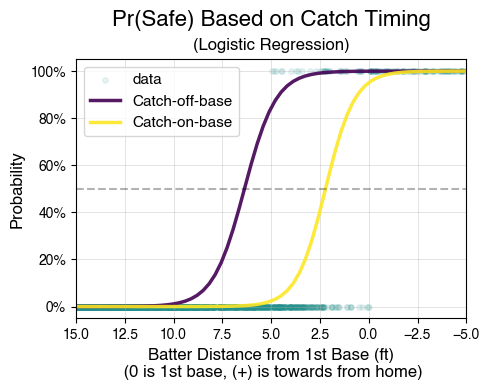

In [57]:
"""
Calculate Pr(Safe|CatchOff) 
    (Logistic regression just CatchResults.ipynb)
    1. Clean data
    2. Prepare logistic regression
    3. Fit
    4. Evaluate
    5. Visualization
"""
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.ticker import PercentFormatter

## 1. Clean data
catchoff = contest_catch_results[contest_catch_results['pr_CatchOff'] > 0.95]
catchon = contest_catch_results[contest_catch_results['pr_CatchOn'] > 0.95]
# Remove NaN
catchoff = catchoff.dropna(subset=['ft_til_1st'])
catchon = catchon.dropna(subset=['ft_til_1st'])
print("len(catchon): ",len(catchoff))
print("len(catchon): ",len(catchon))

## 2. Prepare logistic regression
catchoff['safe_int'] = catchoff['safe'].astype('Int64')
catchon['safe_int'] = catchon['safe'].astype('Int64')
X = catchoff[['ft_til_1st']]
y = catchoff['safe_int']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## 3. Fit
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
# Save model
import pickle
with open('../Models/safe_probability_catchoff_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

## 4. Evaulate
y_pred = clf.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Interpretation
coef = clf.coef_[0][0]
odds_ratio = np.exp(coef)
print(f"\nCoefficient for 'ft_til_1st': {coef:.4f}")
print(f"  → Every one-unit increase in ft_til_1st multiplies odds of safe=1 by {odds_ratio:.4f}")

## 5. Visualization
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
x_vals_simul = np.linspace(X['ft_til_1st'].min(), X['ft_til_1st'].max(), 300).reshape(-1, 1) 
y_probs = clf.predict_proba(x_vals_simul)[:, 1]  # Predict probability (not class) for smooth curve
# Compare with CatchOn
with open('../Models/safe_probability_model.pkl', 'rb') as f:
    safe_probability_model = pickle.load(f)
y_probs_catchon = safe_probability_model.predict_proba(x_vals_simul)[:, 1]  # Predict probability (not class) for smooth curve
# Plot
plt.figure(figsize=(5, 4)) 
plt.scatter(catchoff['ft_til_1st'], catchoff['safe_int'], alpha=0.1, s=15, color=colors[1], label='data') 
plt.scatter(catchon['ft_til_1st'], catchon['safe_int'], alpha=0.1, s=15, color=colors[1]) 
plt.plot(x_vals_simul, y_probs, linewidth=2.5, alpha=0.9, color=colors[0], label='Catch-off-base')
plt.plot(x_vals_simul, y_probs_catchon, linewidth=2.5, alpha=0.9, color=colors[2], label='Catch-on-base')
plt.xlabel("Batter Distance from 1st Base (ft)\n (0 is 1st base, (+) is towards from home)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Pr(Safe) Based on Catch Timing", fontsize=16, pad=24)
plt.text(x=9.0,y=1.09,s="(Logistic Regression)",fontsize=12)
plt.axhline(0.5, color='black', linestyle='--', alpha=0.3)
plt.xlim(-5,15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.gca().invert_xaxis()
plt.legend(fontsize=11)
plt.grid(True, lw=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

In [58]:
"""
Define target plane
    Using throw_infos.csv (from ArmStrength.ipynb)
    Define catchable region sphere
    Then define a 2D plane tangent to that circle,
        perpendicular to the straight line from
        player to base  
    
1. Get ball position at release
2. Draw a straight line from ball position at release to 1st base
3. Find a point on the catchable region sphere that intersects the line
4. Find 2D plane that's normal to the line at the intersection 
"""
## 1. Get ball position at release
# (Use ball pos from ArmStrength.ipynb that accounts for occlusion)
# (This assumes that release height tends to be closer to acquiring height—than not)
throw_infos = pd.read_csv('../CSV/throw_infos.csv')
throw_infos = throw_infos[['game_str','play_id','throw_ts','ball_rel_x_adj','ball_rel_y_adj','ball_rel_z_adj']]
throw_infos = throw_infos.rename(columns={'throw_ts':'thr_ts'})
ball_rel = contest_catch_results.merge(throw_infos,how='left',on=['game_str','play_id','thr_ts'])
ball_rel = ball_rel.dropna(subset=['ball_rel_x_adj','ball_rel_y_adj','ball_rel_z_adj'])

## 2. Draw a straight line from ball position at release to 1st base
# Vector from (x0,y0,z0) to (x1,y1,z1) is (x1-x0,y1-y0,z1-z0)
# So line going through 2 points is (x0,y0,z0) + (x1-x0,y1-y0,z1-z0)t (Parametric form)
# Since base = (x0,y0,z0) is always same, we just need to save the latter
def find_direction_vector(row):
    return [row['ball_rel_x_adj'] - 63.64, 
            row['ball_rel_y_adj'] - 63.64, 
            row['ball_rel_z_adj'] - 0]
ball_rel['line_vec'] = ball_rel.apply(lambda row: find_direction_vector(row), axis=1)

## 3. Find a point on the catchable region sphere that intersects the line
# (There should slways be 2 intersections since the line goes through the middle)
# We can make this convenient by assuming 1st base (63.64,63.64,0) is the origin
# (Then translate later)
# Formula from: https://en.wikipedia.org/wiki/Line%E2%80%93sphere_intersection
# Solve quadratic formula and get t
#   a = u = ||(x1-x0,y1-y0,z1-z0)||²
#   b = 2u
#   c = -r²
#   Intersection points: x = tu
RADIUS = 9.5  # (Consistent with CatchResults.ipynb)
ball_rel['u'] = ball_rel['line_vec'].apply(lambda v: np.linalg.norm(v,ord=2))
def find_quadratic_coefficients(row):
    return [row['u']**2, row['u']*2, -RADIUS**2]
ball_rel['quad_coef'] = ball_rel.apply(lambda row: find_quadratic_coefficients(row), axis=1)
ball_rel['roots'] = ball_rel['quad_coef'].apply(lambda v: np.roots(v)) # Always 2 roots as mentioned above
ball_rel['real_root'] = ball_rel['roots'].apply(lambda arr: max(arr)) # One and only one of them must be real
                                                                      # (We take the real root since we're using
                                                                      #  (x1-x0,y1-y0,z1-z0) not
                                                                      #  (x0-x1,y0-x1,z0-z1)
                                                                      #  (I.e. vector starting from 1st base))
def find_intersection(row):
    intersection = [row['line_vec'][0] * row['real_root'],
                    row['line_vec'][1] * row['real_root'], 
                    row['line_vec'][2] * row['real_root']]
    return intersection
ball_rel['intersection'] = ball_rel.apply(lambda row: find_intersection(row), axis=1)

## 4. Find 2D plane that's normal to the line at the intersection 
# (I.e. the intersection is the origin)
# A 2D plane in 3D space has equation:
#   v1(x-a) + v2(y-b) + v3(z-c) = 0
#   Where (v1, v2, v3) is the normal vector
#         (a, b, c) is the origin
# We already have everything
# Just normalize the normal vector
# And translate intersection into world origin (as mentioned above)
def normalize_vector(row):
    return [row['line_vec'][0]/row['u'], row['line_vec'][1]/row['u'], row['line_vec'][2]/row['u']]
ball_rel['plane_normal_vector'] = ball_rel.apply(lambda row: normalize_vector(row),axis=1)
def translate_intersection(arr):
    return [arr[0] + 63.64, arr[1] + 63.64, arr[2] + 0]
ball_rel['plane_origin'] = ball_rel['intersection'].apply(lambda arr: translate_intersection(arr))

## Clean
ball_rel = ball_rel.drop(columns=['line_vec','u','quad_coef','roots','real_root','intersection'])
ball_rel.head(1)

,game_str,play_id,safe,advanced,thr_ts,acq_ts,arr_ts,target_base,nth_throw,ft_til_1st,...,pr_CatchOff,pr_Dropped,pr_Passed,pr_Out_ifcatchOn,pr_Safe_ifcatchOn,ball_rel_x_adj,ball_rel_y_adj,ball_rel_z_adj,plane_normal_vector,plane_origin
0,y1_d001_CGA_QEA,21,True,False,563799,563149.0,564699.0,first,2,-1.802771,...,0.004603,0.0,0.0,0.004603,0.995397,2.95094,122.87892,4.18248,"[-0.7147359797647528, 0.6976576626851725, 0.04...","[57.52723011962167, 69.60670780262205, 0.42127..."


In [59]:
"""
Get location & flight characteristics of the ball 
    (At it's intersection with the target plane)
    1. Get the ball's travel direction (between that point and the next) 
        (I.e. Get direction angle)
        (I.e Spherical coordinates except radius—see plane orientation stuff below)
    2. Find a point closest but preceding the target plane
    3. Calculate expected intersection time
    4. Project point onto the plane to find intersection
    5. Get the xy vectors of the plane
    6. Find the xy coordinates of the projected point on the plane
    7. Simplify plane representation by just keeping orientation
        (I.e Spherical coordinates except radius)
"""
ball_pos = ball_position_subset.to_table(columns=['game_str','play_id','timestamp','ball_position_x','ball_position_y','ball_position_z']).to_pandas()
# Filter for throws
ball_filt = ball_rel[['game_str','play_id','thr_ts','plane_normal_vector','plane_origin']]
ball_afterthr = ball_filt.merge(ball_pos,how='left',on=['game_str','play_id'])

## 1. Get the ball's speed / travel direction (between that point and the next)
# (I.e. Get direction angle)
# (I.e Spherical coordinates except radius—see plane orientation stuff below)
ball_afterthr['ball_position_x_diff'] = (
    ball_afterthr.groupby(['game_str', 'play_id'])['ball_position_x'].diff(-1) * -1)
ball_afterthr['ball_position_y_diff'] = (
    ball_afterthr.groupby(['game_str', 'play_id'])['ball_position_y'].diff(-1) * -1)
ball_afterthr['ball_position_z_diff'] = (
    ball_afterthr.groupby(['game_str', 'play_id'])['ball_position_z'].diff(-1) * -1)
# Ball speed
ball_afterthr['ball_spd'] = np.sqrt(ball_afterthr['ball_position_x_diff']**2 + ball_afterthr['ball_position_y_diff']**2 + ball_afterthr['ball_position_z_diff']**2)
# Ball travel direction
def get_ball_direction(row):
    x_diff,y_diff,z_diff = row['ball_position_x_diff'],row['ball_position_y_diff'],row['ball_position_z_diff']
    # At polar_angle == 0, the ball goes right (towards (+) x-axis)
    # As angle increases/decreases, angles goes counterclockwise/clockwise
    polar_angle = np.degrees(np.arctan2(y_diff,x_diff))
    # azimuthal_angle == 0 means parallel with ground
    azimuthal_angle = np.degrees(np.arctan2(z_diff,np.hypot(x_diff,y_diff)))
    return [polar_angle, azimuthal_angle]
ball_afterthr['ball_direction'] = ball_afterthr.apply(lambda row: get_ball_direction(row),axis=1)

## 2. Find a point closest but preceding the target plane
# Filter for only positions after ball thrown
ball_afterthr = ball_afterthr[ball_afterthr['timestamp'] > ball_afterthr['thr_ts']]
# Find dist
def find_dist(row):
    """Recall equation from above:
    #   v1(x-a) + v2(y-b) + v3(z-c) = q
    #   Where (v1, v2, v3) is the normal vector
    #         (a, b, c) is the origin
    #   q==0 if point on the plane
    """
    v1, v2, v3 = row['plane_normal_vector'][0], row['plane_normal_vector'][1], row['plane_normal_vector'][2]
    a, b, c = row['plane_origin'][0], row['plane_origin'][1], row['plane_origin'][2] 
    return v1*(row['ball_position_x']-a) + v2*(row['ball_position_y']-b) + v3*(row['ball_position_z']-c)
ball_afterthr['dist'] = ball_afterthr.apply(lambda row: find_dist(row), axis=1)
# Filter out all points that passed the target plane
ball_afterthr = ball_afterthr[ball_afterthr['dist']>=0]
# Get closest point
mask = ball_afterthr['dist'] == ball_afterthr.groupby(['game_str','play_id'])['dist'].transform('min')
closest_points = ball_afterthr[mask]

## 3. Calculate expected intersection time
# (This is a rough estimate since ball isn't necessarily traveling directly towards target plane)
# (But should be good enough)
closest_points['E_itsx_ts'] = closest_points['timestamp'] + (closest_points['dist']/closest_points['ball_spd'])

## 4. Project point onto the plane to find intersection
def find_projection(row):
    # Keep in mind the normal vector is normalized
    # So projection Q = A + sn   (A is given point, n is normal vector)
    # Where s = n ⋅ (P_0 - A)    (P_0 is any point on plane)
    given_point = np.array([row['ball_position_x'], row['ball_position_y'], row['ball_position_z']])
    plane_origin = np.array(row['plane_origin'])
    normal = np.array(row['plane_normal_vector'])
    s = np.dot(normal, plane_origin - given_point)
    return given_point + s * normal
closest_points['projection'] = closest_points.apply(lambda row: find_projection(row),axis=1)

## 5. Get the xy vectors of the plane
# (The x vector should be horizontal; parallel to the ground)
#   (So x vector (x1,x2,0) that's perpendicular to the normal vector (v1,v2,v3))
#   (We can simply use (-v2,v1,0) so that it's dot product is 0)
def get_x_vector(arr):
    return [-arr[1],arr[0],0]
closest_points['plane_x_vector'] = closest_points['plane_normal_vector'].apply(lambda row: get_x_vector(row))
# (The y vector is perpendicular to both normal vector & x vector)
#   (So cross product of (v1,v2,v3) and (-v2,v1,0))
#   (Use the formula a×b = (a2b3-a3b2, a3b1-a1b3, a1b2-a2b1))
#                        = (-v3v1, -v3v2, v1v1+v2v2)
def get_y_vector(arr):
    y_vec = [-arr[2]*arr[0], -arr[2]*arr[1], arr[0]**2+arr[1]**2]
    length = np.linalg.norm(y_vec, ord=2)
    y_vec_normalized = [y_vec[i]/length for i in range(len(y_vec))]
    return y_vec_normalized
closest_points['plane_y_vector'] = closest_points['plane_normal_vector'].apply(lambda row: get_y_vector(row))

## 6. Find the xy coordinates of the projected point on the plane
# The xy coordinates of the projected point is the dot product with the xy vectors
# (After translating the plane's origin with world origins)
def get_xy_coordinates(row):
    proj_x,proj_y,proj_z = row['projection'][0]-63.64, row['projection'][1]-63.64, row['projection'][2]-0
    d = [proj_x,proj_y,proj_z]
    return [np.dot(d,row['plane_x_vector']), np.dot(d,row['plane_y_vector'])]
closest_points['ball_pos_xy_plane'] = closest_points.apply(lambda row: get_xy_coordinates(row),axis=1)

## 6. Simplify plane representation by just keeping orientation
# (I.e Spherical coordinates except radius)
def get_plane_orientation(arr):
    # At polar_angle == 0, the plane (normal vector) faces right (towards (+) x-axis)
    # As angle increases/decreases, the plane rotates counterclockwise/clockwise
    polar_angle = np.degrees(np.arctan2(arr[1],arr[0]))
    # At azimuthal_angle == 0, the plane (normal vector) is vertical
    azimuthal_angle = np.degrees(np.arctan2(arr[2],np.hypot(arr[0],arr[1])))
    return [polar_angle, azimuthal_angle]
closest_points['plane_orientation'] = closest_points['plane_normal_vector'].apply(lambda arr: get_plane_orientation(arr))
# Include plane origin's elevation
closest_points['proj_ball_z'] = closest_points['projection'].apply(lambda arr: arr[2])

## Organize
ball_plane_info = closest_points[['game_str','play_id','thr_ts','timestamp','E_itsx_ts',
                                  'proj_ball_z','plane_orientation','ball_pos_xy_plane',
                                  'ball_direction','projection']]

ball_plane_info.head(1)

C:\Users\mla21\AppData\Local\Temp\ipykernel_21852\2869633730.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_points['E_itsx_ts'] = closest_points['timestamp'] + (closest_points['dist']/closest_points['ball_spd'])
C:\Users\mla21\AppData\Local\Temp\ipykernel_21852\2869633730.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_points['projection'] = closest_points.apply(lambda row: find_projection(row),axis=1)
C:\Users\mla21\AppData\Local\Temp\ipykernel_21852\2869633730.py:86: SettingWith

,game_str,play_id,thr_ts,timestamp,E_itsx_ts,proj_ball_z,plane_orientation,ball_pos_xy_plane,ball_direction,projection
66,y1_d001_CGA_QEA,21,563799,564599,564599.774035,6.894816,"[135.69277273337028, 2.8233681933295487]","[2.295173527626711, 6.4814125281035855]","[-51.9207973749416, -6.292179135673615]","[56.15055114358677, 67.7392729333467, 6.894815..."


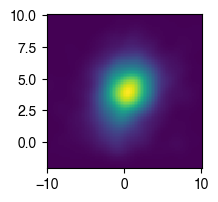

In [60]:
# 2d KDE of location on target
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Data
ball_pos_plane = pd.DataFrame(ball_plane_info['ball_pos_xy_plane'].tolist(), index=ball_plane_info.index)
x = ball_pos_plane[0].values
y = ball_pos_plane[1].values

nbins=100
k = gaussian_kde([x,y])
xi, yi = np.mgrid[-10:10:nbins*1j,-2:10:nbins*1j]
zi = k(np.vstack([
   xi.flatten(),
   yi.flatten()
])).reshape(xi.shape)

fig, ax = plt.subplots(figsize=(2,2))
ax.pcolormesh(xi, yi, zi)
plt.show()


In [61]:
"""
Get ft_til_1st at intersection
    Using running_smooth.csv (from Running.ipynb)
    1. Merge running_smooth
    2. Estimate ft_til_1st at intersection
"""
## 1. Merge running_smooth
running_smooth = pd.read_csv('../CSV/running_smooth.csv')
running_itsx = running_smooth[['game_str','play_id','timestamp','ft_til_1st_sm','spd_to_1st_sm']]
ball_plane_run = ball_plane_info.merge(running_itsx,how='left',on=['game_str','play_id','timestamp'])

## 2. Estimate ft_til_1st at intersection
ball_plane_run['fill_remaining_ts'] = ball_plane_run['E_itsx_ts'] - ball_plane_run['timestamp']
ball_plane_run['E_ft_til_1st_itsx'] = (
    ball_plane_run['ft_til_1st_sm'] - (ball_plane_run['spd_to_1st_sm'] * ball_plane_run['fill_remaining_ts'] / 1000))

## Organize
ball_plane_run = ball_plane_run.drop(['ft_til_1st_sm','spd_to_1st_sm','fill_remaining_ts'],axis=1)
ball_plane_run = ball_plane_run.rename(columns={'timestamp':'closest_itsx_ts'})
ball_plane_run.head(1)

,game_str,play_id,thr_ts,closest_itsx_ts,E_itsx_ts,proj_ball_z,plane_orientation,ball_pos_xy_plane,ball_direction,projection,E_ft_til_1st_itsx
0,y1_d001_CGA_QEA,21,563799,564599,564599.774035,6.894816,"[135.69277273337028, 2.8233681933295487]","[2.295173527626711, 6.4814125281035855]","[-51.9207973749416, -6.292179135673615]","[56.15055114358677, 67.7392729333467, 6.894815...",0.9762


In [62]:
"""
Prepare dataset for machine learning modeling
    (Get expected time between intersection & catch)
    (Feature engineering)
    Using everything above
    1. Merge contest_catch_results and all the features created so far
    2. Calculate time between intersection & catch
    3. Expand the arrays into individual features
    4. Embed angles to have no overlapping
    5. Embed target plane ball location
    6. Organize dataframe
"""
# Set seed for replicability
SEED = 42
np.random.seed(SEED)  

## 1. Merge contest_catch_results and all the features created so far
ball_plane_run_clean = ball_plane_run.merge(contest_catch_results,how='left',on=['game_str','play_id','thr_ts'])

## 2. Calculate time between intersection & catch
# (It's safe to assume arr_ts is catch_ts because 
#  we'll only be using this for CatchOn's)
ball_plane_run_clean['itsx_catch_ts_delta'] = ball_plane_run_clean['arr_ts'] - ball_plane_run_clean['E_itsx_ts']

## 3. Expand the arrays into individual features
ball_plane_run_clean[['plane_orientation_polar','plane_orientation_azimuth']] = pd.DataFrame(ball_plane_run_clean['plane_orientation'].tolist(), index=ball_plane_run_clean.index)
ball_plane_run_clean[['ball_pos_x_plane','ball_pos_y_plane']] = pd.DataFrame(ball_plane_run_clean['ball_pos_xy_plane'].tolist(), index=ball_plane_run_clean.index)
ball_plane_run_clean[['ball_direction_polar','ball_direction_azimuth']] = pd.DataFrame(ball_plane_run_clean['ball_direction'].tolist(), index=ball_plane_run_clean.index)

## 4. Embed angles to have no overlapping
# (E.g. 359° and -1° is same)
# (Convert [-360°,360°) to [-180°,180°))
ball_plane_run_clean['plane_orientation_polar'] = ball_plane_run_clean['plane_orientation_polar'].apply(lambda deg: ((deg + 180) % 360) - 180)
ball_plane_run_clean['plane_orientation_azimuth'] = ball_plane_run_clean['plane_orientation_azimuth'].apply(lambda deg: ((deg + 180) % 360) - 180)
# For ball direction it's not necessary because 1st base is on the right side of the field
ball_plane_run_clean['plane_orientation_polar'] = ball_plane_run_clean['plane_orientation_polar'].apply(lambda deg: ((deg + 180) % 360) - 180)
ball_plane_run_clean['plane_orientation_azimuth'] = ball_plane_run_clean['plane_orientation_azimuth'].apply(lambda deg: ((deg + 180) % 360) - 180)

## 5. Embed target plane ball location
# (Somewhat-polar embedding)
# (Using pure polar coordinates causes discontinuity 
#  in 360-0, or -180-180, or so on)
ball_plane_run_clean['ball_dis_plane_origin'] = np.sqrt(ball_plane_run_clean['ball_pos_x_plane']**2 + ball_plane_run_clean['ball_pos_y_plane']**2)
# Normalize x, y
ball_plane_run_clean['ball_norm_x_plane'] = ball_plane_run_clean['ball_pos_x_plane']/ball_plane_run_clean['ball_dis_plane_origin']
ball_plane_run_clean['ball_norm_y_plane'] = ball_plane_run_clean['ball_pos_y_plane']/ball_plane_run_clean['ball_dis_plane_origin']

## 6. Organize dataframe
# Convert Probabilistic Labels to Hard Labels
def sample_from_probabilities(row):
    pr_CatchOn,pr_CatchOff,pr_Dropped,pr_Passed = row['pr_CatchOn'],row['pr_CatchOff'],row['pr_Dropped'],row['pr_Passed']
    return np.random.choice([0,1,2,3],size=1,p=[pr_CatchOn,pr_CatchOff,pr_Dropped,pr_Passed])[0]
ball_plane_run_clean['target'] = ball_plane_run_clean.apply(lambda row: sample_from_probabilities(row), axis=1)
# Only keep features/targets
prep_ds = ball_plane_run_clean[['plane_orientation_polar',
                   'plane_orientation_azimuth',
                   'ball_norm_x_plane',
                  #  'ball_norm_y_plane',
                   'proj_ball_z',
                   'ball_dis_plane_origin',
                   'ball_direction_polar',
                   'ball_direction_azimuth',
                   'E_ft_til_1st_itsx','itsx_catch_ts_delta',
                   'pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed','target']]

# (We don't need to drop the feature NA's because XGBoost can handle missing columns)
# ball_plane_run_clean.dropna(how='any', inplace=True)

print(prep_ds.groupby('target').size())
prep_ds.head(1)

target
0    3164
1     122
2      19
3      62
dtype: int64


,plane_orientation_polar,plane_orientation_azimuth,ball_norm_x_plane,proj_ball_z,ball_dis_plane_origin,ball_direction_polar,ball_direction_azimuth,E_ft_til_1st_itsx,itsx_catch_ts_delta,pr_CatchOn,pr_CatchOff,pr_Dropped,pr_Passed,target
0,135.692773,2.823368,0.333805,6.894816,6.875793,-51.920797,-6.292179,0.9762,99.225965,0.995397,0.004603,0.0,0.0,0


In [63]:
"""
Export
"""
ball_plane_run_clean = ball_plane_run_clean[
    ['game_str','play_id','nth_throw','safe','advanced','thr_ts','acq_ts','arr_ts',
     'closest_itsx_ts','E_itsx_ts','E_ft_til_1st_itsx','ft_til_1st','itsx_catch_ts_delta',
     'plane_orientation_polar','plane_orientation_azimuth','ball_norm_x_plane','ball_dis_plane_origin','proj_ball_z','ball_direction_polar','ball_direction_azimuth',
     ]]
ball_plane_run_clean.to_csv('../CSV/ball_plane_run_clean.csv', index=False)
ball_plane_run_clean.head(1)

,game_str,play_id,nth_throw,safe,advanced,thr_ts,acq_ts,arr_ts,closest_itsx_ts,E_itsx_ts,E_ft_til_1st_itsx,ft_til_1st,itsx_catch_ts_delta,plane_orientation_polar,plane_orientation_azimuth,ball_norm_x_plane,ball_dis_plane_origin,proj_ball_z,ball_direction_polar,ball_direction_azimuth
0,y1_d001_CGA_QEA,21,2,True,False,563799,563149.0,564699.0,564599,564599.774035,0.9762,-1.802771,99.225965,135.692773,2.823368,0.333805,6.875793,6.894816,-51.920797,-6.292179


In [64]:
"""
Fit ML model for catch result classification
    1. Get X, y
    2. Split X, y into train/val/test
    3. Get sample weights to counter imbalance
    4. Create prep data structures
    5. Train XGBoost
    6. Train Catboost
    7. Train LGBM

    (To prevent overfitting, we focus more on variance
     reduction and less on decreasing loss)
"""
import xgboost as xgb
import catboost as cat
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import optuna
SEED = 42
sampler = optuna.samplers.TPESampler(seed=SEED)

## 1. Get X, y
X = prep_ds.drop(columns=['itsx_catch_ts_delta',  # This is for other model
                          'pr_CatchOn','pr_CatchOff','pr_Dropped','pr_Passed','target']
                          ).astype(np.float32)
y = prep_ds['target'].astype(np.int64)

## 2. Split X, y into train/val/test
# (Use stratify to get even train test splits)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=SEED, stratify=y_trainval)

## 3. Get sample weights to counter imbalance
train_weights = compute_sample_weight("balanced", y_train)
val_weights   = compute_sample_weight("balanced", y_val)
test_weights = compute_sample_weight("balanced", y_test)

## 4. Create prep data structures
# XGBoost DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train, weight=train_weights)
dval   = xgb.DMatrix(X_val,   label=y_val,   weight=val_weights)
dtest  = xgb.DMatrix(X_test,  label=y_test,  weight=test_weights)
# Catboost Pool
train_pool = cat.Pool(X_train, label=y_train, weight=train_weights)
val_pool   = cat.Pool(X_val,   label=y_val,   weight=val_weights)
test_pool  = cat.Pool(X_test,  label=y_test,  weight=test_weights)
# LGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, weight=train_weights)
val_data   = lgb.Dataset(X_val,   label=y_val,   weight=val_weights)
test_data  = lgb.Dataset(X_test,  label=y_test,  weight=test_weights)

## 5. Train XGBoost
OPTUNA_NTRIALS_XGB = 10
print("Starting optuna XGBoost study...")
xgb_models = []
def objective_xgb(trial: optuna.Trial):
    model = xgb.train(
        {   'objective': "multi:softprob",
            'eval_metric': "mlogloss",
            # 'device': 'cuda',
            'tree_method': 'hist',
            'num_class': 4,
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            # "max_leaves": trial.suggest_int("max_leaves", 1, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
            'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),      # L1 reg
            'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),    # L2 reg
            'gamma': trial.suggest_float('gamma', 0, 5.0),  
            'verbosity':  0,
            'seed': SEED   },
        dtrain,
        num_boost_round=10000,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=1000,
        verbose_eval=0 )
    xgb_models.append(model)
    y_prob = model.predict(dtest)
    y_true = dtest.get_label() 
    return log_loss(y_true, y_prob, sample_weight=test_weights)
# XGBoost study
xgb_study = optuna.create_study(direction="minimize", sampler=sampler)
xgb_study.optimize(objective_xgb, n_trials=OPTUNA_NTRIALS_XGB)

## 6. Train CatBoost
OPTUNA_NTRIALS_CAT = 10
print("Starting optuna CatBoost study...")
cat_models = []
def objective_cat(trial: optuna.Trial):
    params = {  "loss_function": "MultiClass",
                # "task_type": "GPU", 
                "depth": trial.suggest_int("depth", 1, 10),
                # "max_leaves": trial.suggest_int("max_leaves", 1, 20),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
                'min_data_in_leaf': trial.suggest_float('min_data_in_leaf', 1, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
                "iterations": 10000,  # num_boost_round
                "verbose": False,
                "random_seed": SEED   }
    model = cat.CatBoostClassifier(**params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=1000,
        use_best_model=True,
        verbose=0)
    cat_models.append(model)
    y_prob = model.predict_proba(test_pool)
    y_true = test_pool.get_label() 
    return log_loss(y_true, y_prob, sample_weight=test_weights)
# CatBoost study
cat_study = optuna.create_study(direction="minimize", sampler=sampler)
cat_study.optimize(objective_cat, n_trials=OPTUNA_NTRIALS_CAT)

## 7. Train LightGBM
OPTUNA_NTRIALS_LGB = 10
print("Starting optuna LightGBM study...")
lgb_models = []
def objective_lgb(trial: optuna.Trial):
    params = {
    "objective": "multiclass",
    "num_class": 4,
    "metric": "multi_logloss",
    # "device_type": "gpu",
    'max_depth': trial.suggest_int('max_depth', 1, 10),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
    # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 5.0),
    "verbosity": -1, 
    "seed": SEED  }
    model = lgb.train(
        params,
        train_set=train_data,
        num_boost_round=10000,
        valid_sets=[val_data], 
        callbacks=[
            lgb.early_stopping(1000),  # early_stopping_rounds
            lgb.log_evaluation(period=0)]  # verbose_eval
    )
    lgb_models.append(model)
    y_prob = model.predict(X_test)
    return log_loss(y_test, y_prob, sample_weight=test_weights)
# LightGBM study
lgb_study = optuna.create_study(direction="minimize", sampler=sampler)
lgb_study.optimize(objective_lgb, n_trials=OPTUNA_NTRIALS_LGB)

[I 2025-08-01 12:07:51,740] A new study created in memory with name: no-name-65ae74a6-8a64-45ee-af55-2adcaf472720


Starting optuna XGBoost study...


[I 2025-08-01 12:07:59,172] Trial 0 finished with value: 1.1808663394814043 and parameters: {'max_depth': 4, 'learning_rate': 0.08927180304353628, 'min_child_weight': 7.587945476302646, 'alpha': 0.0024430162614261413, 'lambda': 2.5361081166471375e-07, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 1.1808663394814043.
[I 2025-08-01 12:08:06,855] Trial 1 finished with value: 0.9092376550176934 and parameters: {'max_depth': 1, 'learning_rate': 0.07348118405270448, 'min_child_weight': 6.41003510568888, 'alpha': 0.023585940584142682, 'lambda': 1.5320059381854043e-08, 'gamma': 4.8495492608099715}. Best is trial 1 with value: 0.9092376550176934.
[I 2025-08-01 12:08:17,405] Trial 2 finished with value: 1.098095869608549 and parameters: {'max_depth': 9, 'learning_rate': 0.016305687346221478, 'min_child_weight': 2.636424704863906, 'alpha': 4.4734294104626844e-07, 'lambda': 5.472429642032198e-06, 'gamma': 2.6237821581611893}. Best is trial 1 with value: 0.9092376550176934.
[I 2025-08-0

Starting optuna CatBoost study...


[I 2025-08-01 12:10:00,784] Trial 0 finished with value: 0.9687926849125151 and parameters: {'depth': 4, 'learning_rate': 0.01867880257107068, 'min_data_in_leaf': 8.458637582367365, 'l2_leaf_reg': 1.6247252885719427e-05}. Best is trial 0 with value: 0.9687926849125151.
[I 2025-08-01 12:10:13,579] Trial 1 finished with value: 0.9941706007936907 and parameters: {'depth': 3, 'learning_rate': 0.03488960745139221, 'min_data_in_leaf': 2.2683180247728636, 'l2_leaf_reg': 0.16587190283399655}. Best is trial 0 with value: 0.9687926849125151.
[I 2025-08-01 12:10:20,441] Trial 2 finished with value: 1.0428489260608953 and parameters: {'depth': 1, 'learning_rate': 0.09702573394120728, 'min_data_in_leaf': 7.9502029236699165, 'l2_leaf_reg': 6.143857495033091e-07}. Best is trial 0 with value: 0.9687926849125151.
[I 2025-08-01 12:10:27,096] Trial 3 finished with value: 1.010434897408033 and parameters: {'depth': 1, 'learning_rate': 0.06538248584518043, 'min_data_in_leaf': 7.361716094628554, 'l2_leaf_re

Starting optuna LightGBM study...
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:00,813] Trial 0 finished with value: 0.9147619529714115 and parameters: {'max_depth': 1, 'learning_rate': 0.04329227527579915, 'lambda_l1': 6.748446817464346e-06, 'lambda_l2': 0.0003776906385115029, 'min_split_gain': 4.537832369630465}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 1.20753
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:02,098] Trial 1 finished with value: 0.9543511963124109 and parameters: {'max_depth': 3, 'learning_rate': 0.02572663133249956, 'lambda_l1': 0.06308995924905789, 'lambda_l2': 1.1459970229341322e-06, 'min_split_gain': 0.38489954914396496}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 1.22896
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:03,049] Trial 2 finished with value: 0.9779714424914658 and parameters: {'max_depth': 3, 'learning_rate': 0.014495102383254688, 'lambda_l1': 2.3295866619309256, 'lambda_l2': 0.18753546777666233, 'min_split_gain': 3.1670187825521174}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 1.23255
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:03,737] Trial 3 finished with value: 1.1052165389231385 and parameters: {'max_depth': 9, 'learning_rate': 0.06363148766597145, 'lambda_l1': 4.776728196949699e-07, 'lambda_l2': 1.0790237065789294, 'min_split_gain': 2.6967112095782535}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[9]	valid_0's multi_logloss: 1.25884
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:04,458] Trial 4 finished with value: 1.1356277540907955 and parameters: {'max_depth': 9, 'learning_rate': 0.07872112644525067, 'lambda_l1': 7.278322158604965e-06, 'lambda_l2': 9.782893389157736e-08, 'min_split_gain': 1.1396758127097084}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[7]	valid_0's multi_logloss: 1.23571
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:05,102] Trial 5 finished with value: 1.0772588611567033 and parameters: {'max_depth': 5, 'learning_rate': 0.06576801979658928, 'lambda_l1': 0.557924264150636, 'lambda_l2': 1.1549659339590204e-08, 'min_split_gain': 2.553736512887829}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[8]	valid_0's multi_logloss: 1.24466
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:05,979] Trial 6 finished with value: 1.0905431363675093 and parameters: {'max_depth': 5, 'learning_rate': 0.016676611460145475, 'lambda_l1': 1.1989147575590843e-07, 'lambda_l2': 1.0927895733904103e-05, 'min_split_gain': 4.714548519562596}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 1.24979
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:06,525] Trial 7 finished with value: 1.0594530214500761 and parameters: {'max_depth': 4, 'learning_rate': 0.03302103045515254, 'lambda_l1': 0.02124078827890451, 'lambda_l2': 1.8735548907110496e-05, 'min_split_gain': 4.858910413604804}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 1.2531
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:07,859] Trial 8 finished with value: 1.1444544712868274 and parameters: {'max_depth': 10, 'learning_rate': 0.017855922645162278, 'lambda_l1': 0.00029870091504560114, 'lambda_l2': 5.103930927389519e-06, 'min_split_gain': 1.424202471887338}. Best is trial 0 with value: 0.9147619529714115.


Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 1.23764
Training until validation scores don't improve for 1000 rounds


[I 2025-08-01 12:19:08,733] Trial 9 finished with value: 0.9058021891343132 and parameters: {'max_depth': 1, 'learning_rate': 0.0406971815895597, 'lambda_l1': 0.0003342806277473177, 'lambda_l2': 2.906088000706637e-08, 'min_split_gain': 1.3932323211830573}. Best is trial 9 with value: 0.9058021891343132.


Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 1.20635


In [65]:
"""
Create & evaluate the ensemble
    1. Create model ensembles
        (Save models)
    2. Get predictions/loss from each ensemble
    3. Using loss, calculate weighted ensemble
    4. Evaluate ensemble
    5. Visualize
"""
import warnings
import pickle
from scipy.optimize import minimize

## 1. Create model ensembles
# Get top models
TOP = 1
xgb_trials = [t for t in xgb_study.trials if t.value is not None]
top_10_xgb = sorted(xgb_trials, key=lambda t: t.value, reverse=False)[:TOP]
top10_ids_xgb = [t.number for t in top_10_xgb]
cat_trials = [t for t in cat_study.trials if t.value is not None]
top_10_cat = sorted(cat_trials, key=lambda t: t.value, reverse=False)[:TOP]
top10_ids_cat = [t.number for t in top_10_cat]
lgb_trials = [t for t in lgb_study.trials if t.value is not None]
top_10_lgb = sorted(lgb_trials, key=lambda t: t.value, reverse=False)[:TOP]
top10_ids_lgb = [t.number for t in top_10_lgb]
# Average the top models
from Helpers import Ensemble
xgb_ensemble = Ensemble([xgb_models[top10_ids_xgb[i]] for i in range(TOP)])
cat_ensemble = Ensemble([cat_models[top10_ids_cat[i]] for i in range(TOP)])
lgb_ensemble = Ensemble([lgb_models[top10_ids_lgb[i]] for i in range(TOP)])
# Save models
for i in range(TOP):
    xgb_models[top10_ids_xgb[i]].save_model(f'../Models/catch_probability_models/catch_probability_model_xgboost_{i}')
    cat_models[top10_ids_cat[i]].save_model(f'../Models/catch_probability_models/catch_probability_model_catboost_{i}')
    lgb_models[top10_ids_lgb[i]].save_model(f'../Models/catch_probability_models/catch_probability_model_lightgbm_{i}')

## 2. Get predictions/loss and compare
y_prob_xgb_naive = xgb_models[0].predict(dtest)
y_prob_cat_naive = cat_models[0].predict_proba(X_test)
y_prob_lgb_naive = lgb_models[0].predict(X_test)
y_prob_xgb_tuned = xgb_models[top10_ids_xgb[0]].predict(dtest)
y_prob_cat_tuned = cat_models[top10_ids_cat[0]].predict_proba(X_test)
y_prob_lgb_tuned = lgb_models[top10_ids_lgb[0]].predict(X_test)
y_prob_xgb_ensemble = xgb_ensemble.predict_proba(X_test)
y_prob_cat_ensemble = cat_ensemble.predict_proba(X_test)
y_prob_lgb_ensemble = lgb_ensemble.predict_proba(X_test)
print("On test data:                  Log loss")
print("XGBoost (Naive):              ", log_loss(y_test, y_prob_xgb_naive, sample_weight=test_weights))
print("CatBoost (Naive):             ", log_loss(y_test, y_prob_cat_naive, sample_weight=test_weights))
print("LightGBM (Naive):             ", log_loss(y_test, y_prob_lgb_naive, sample_weight=test_weights))
print("XGBoost (Fine-tuned):         ", log_loss(y_test, y_prob_xgb_tuned, sample_weight=test_weights))
print("CatBoost (Fine-tuned):        ", log_loss(y_test, y_prob_cat_tuned, sample_weight=test_weights))
print("LightGBM (Fine-tuned):        ", log_loss(y_test, y_prob_lgb_tuned, sample_weight=test_weights))
print("XGBoost (Tuned + Ensemble):   ", log_loss(y_test, y_prob_xgb_ensemble, sample_weight=test_weights))
print("CatBoost (Tuned + Ensemble):  ", log_loss(y_test, y_prob_cat_ensemble, sample_weight=test_weights))
print("LightGBM (Tuned + Ensemble):  ", log_loss(y_test, y_prob_lgb_ensemble, sample_weight=test_weights))

## 3. Using loss, calculate weighted ensemble
# Make a probability tensor
probs = np.stack([y_prob_xgb_ensemble, y_prob_cat_ensemble, y_prob_lgb_ensemble], axis=0)
# Minimize ensemble loss
def ensemble_loss(weights):
    # Get weighted average of probabilities
    weighted_probs = np.tensordot(weights, probs, axes=(0,0))
    with warnings.catch_warnings():  # Silence warning that says prob sum to 1 because it does
        warnings.simplefilter("ignore", UserWarning)
        return log_loss(y_test, weighted_probs, sample_weight=test_weights)
res = minimize(ensemble_loss, x0=np.array([1/3, 1/3, 1/3]), 
               bounds=[(0,1)]*3, constraints=({'type':'eq', 'fun': lambda w: w.sum() - 1}))
optimal_weights = res.x
print("Full Ensemble (All 3 Models): ", ensemble_loss(optimal_weights))
print("Optimal weights:    ", optimal_weights)
# Save optimal weights
with open('../Models/catch_probability_optimal_weights.pkl', 'wb') as f:
    pickle.dump(optimal_weights, f)

## 4. Evaluate ensemble
y_prob_ensemble = (y_prob_xgb_ensemble*optimal_weights[0] + 
                   y_prob_cat_ensemble*optimal_weights[1] + 
                   y_prob_lgb_ensemble*optimal_weights[2])
y_pred_ensemble = np.argmax(y_prob_ensemble, axis=1)
print("\nClassification report:")
print(classification_report(y_test, y_pred_ensemble, digits=4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))
print("\nXGBoost feature importance:")
print(xgb_models[top10_ids_xgb[0]].get_score(importance_type ='gain'))
print("\nCatBoost feature importance:")
print(cat_models[top10_ids_cat[0]].get_feature_importance())

## 5. Visualize
import matplotlib.image as mpimg
import matplotlib.patches as patches
x =  np.linspace(-15,15,100)
y = np.linspace(-1,15,100)
ball_pos_x_plane,ball_pos_y_plane = np.meshgrid(x,y)
# Plot
fig, axs = plt.subplots(2,4, figsize=(16,3.8), sharex=True, dpi=1000)
col_names = ['Catch-on-base', 'Catch-off-base', 'Dropped ball', 'Passed ball']
stickman = mpimg.imread('../Visuals/Stickman.png')
stickman_configs = [[12.5, 17.5, -4, 2], [2.5, 7.5, -4, 2]]
for i in range(2):
    E_ft_til_1st_itsx = 15 if i==0 else 5
    # Create sample data
    test_df = pd.DataFrame({
            'plane_orientation_polar': 155,
            'plane_orientation_azimuth': 8,
            'ball_pos_x_plane': ball_pos_x_plane.flatten(),
            'ball_pos_y_plane': ball_pos_y_plane.flatten(),
            'ball_direction_polar': -25,
            'ball_direction_azimuth': -14,
            'proj_ball_z': ball_pos_y_plane.flatten()+1,
            'E_ft_til_1st_itsx': E_ft_til_1st_itsx })
    test_df['ball_dis_plane_origin'] = np.sqrt(test_df['ball_pos_x_plane']**2 + test_df['ball_pos_y_plane']**2)
    test_df['ball_norm_x_plane'] = test_df['ball_pos_x_plane']/test_df['ball_dis_plane_origin']
    test_df['ball_norm_y_plane'] = test_df['ball_pos_y_plane']/test_df['ball_dis_plane_origin']
    # Save ball_pos_x/y for later visualization
    saved = test_df[['ball_pos_x_plane','ball_pos_y_plane']].copy()
    test_df = test_df[['plane_orientation_polar','plane_orientation_azimuth','ball_norm_x_plane','proj_ball_z','ball_dis_plane_origin','ball_direction_polar','ball_direction_azimuth','E_ft_til_1st_itsx']]
    # Create predictions
    test_y_prob_ensemble = (xgb_ensemble.predict_proba(test_df)*optimal_weights[0] + 
                            cat_ensemble.predict_proba(test_df)*optimal_weights[1] + 
                            lgb_ensemble.predict_proba(test_df)*optimal_weights[2])*100
    for j in range(4):
        test_df[f"pred_{j}"] = test_y_prob_ensemble[:, j]
    # Bring back ball_pos_x/y
    test_df = pd.concat([test_df, saved], axis=1)
    # Plot
    grids = [test_df[['ball_pos_x_plane','ball_pos_y_plane','pred_0']].pivot(index='ball_pos_y_plane',columns='ball_pos_x_plane',values='pred_0'),
             test_df[['ball_pos_x_plane','ball_pos_y_plane','pred_1']].pivot(index='ball_pos_y_plane',columns='ball_pos_x_plane',values='pred_1'),
             test_df[['ball_pos_x_plane','ball_pos_y_plane','pred_2']].pivot(index='ball_pos_y_plane',columns='ball_pos_x_plane',values='pred_2'),
             test_df[['ball_pos_x_plane','ball_pos_y_plane','pred_3']].pivot(index='ball_pos_y_plane',columns='ball_pos_x_plane',values='pred_3')]
    for j in range(4):
        axs[i][j].set_xticks(np.arange(-15, 16, 5))
        axs[i][j].set_yticks(np.arange(-15, 21, 5))
        axs[i][j].imshow(stickman, extent=stickman_configs[i],zorder=2)
        axs[i][j].add_patch(patches.Rectangle((-0.75,-4), width=1.5,height=0.5,facecolor='white',zorder=2,edgecolor='black',lw=0.5))
        im = axs[i][j].imshow(grids[j], aspect='auto', extent=[-15, 15, -4, 15], origin='lower', cmap='viridis')
        if i == 0: 
            axs[i][j].set_title(col_names[j], fontsize=17, pad=8)
        if i == 1:
            axs[i][j].set_xlabel("Ball X/Y position on target plane (ft)", fontsize=13)
fig.suptitle("Catch Probability for Shortstop Throw to 1st Base", fontsize=23, y=1.18)
fig.text(0.5, 1.07, "(Batter 15ft vs. 5ft from 1st base — Shortstop POV — when ball meets target plane (4ft above ground))", 
         ha='center', va='top', fontsize=17)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.03, pad=0.03)
fig.text(0.88, 0.94, "Prob(%)", ha='center', va='top', fontsize=12)
plt.show()

On test data:                  Log loss
XGBoost (Naive):               1.1808663394814043
CatBoost (Naive):              0.9687926849125151
LightGBM (Naive):              0.9147619529714115
XGBoost (Fine-tuned):          0.9088513372206943
CatBoost (Fine-tuned):         0.957318672356007
LightGBM (Fine-tuned):         0.9058021891343132
XGBoost (Tuned + Ensemble):    0.9088513372206943
CatBoost (Tuned + Ensemble):   0.957318672356007
LightGBM (Tuned + Ensemble):   0.9058021891343132
Full Ensemble (All 3 Models):  0.8772119035424716
Optimal weights:     [5.30413494e-01 5.20417043e-18 4.69586506e-01]

Classification report:
              precision    recall  f1-score   support

           0     0.9925    0.8310    0.9046       633
           1     0.2571    0.7200    0.3789        25
           2     0.0833    0.5000    0.1429         4
           3     0.1200    0.5000    0.1935        12

    accuracy                         0.8190       674
   macro avg     0.3632    0.6377    0.4050 

(0.75, 1.2)

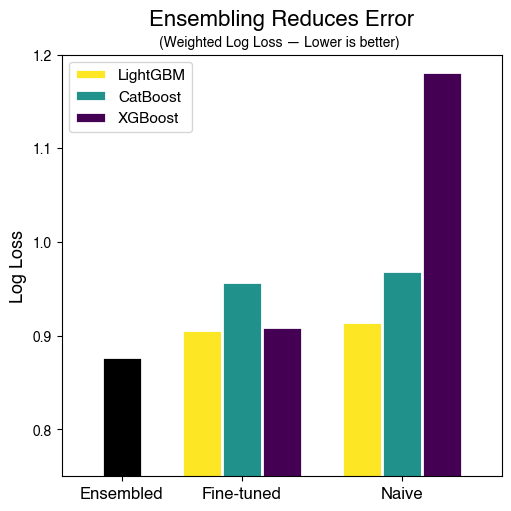

In [66]:
# Extra visualization
techniques = ("Ensembled", "Fine-tuned", "Naive")
model_values = {'XGBoost':  (log_loss(y_test, y_prob_xgb_naive, sample_weight=test_weights),
                             log_loss(y_test, y_prob_xgb_tuned, sample_weight=test_weights),
                             ensemble_loss(optimal_weights)),
                'CatBoost': (log_loss(y_test, y_prob_cat_naive, sample_weight=test_weights),
                             log_loss(y_test, y_prob_cat_tuned, sample_weight=test_weights),
                             ensemble_loss(optimal_weights)),
                'LightGBM': (log_loss(y_test, y_prob_lgb_naive, sample_weight=test_weights),
                             log_loss(y_test, y_prob_lgb_tuned, sample_weight=test_weights),
                             ensemble_loss(optimal_weights))}
# Plot
fig, ax = plt.subplots(layout='constrained', figsize=(5,5), dpi=100)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0,1,3)]
ax.set_xlim(0,2.2)
ax.bar(0.3, ensemble_loss(optimal_weights), width=0.2, color='black', edgecolor='white', lw=2)
line1 = ax.bar(0.7, model_values['LightGBM'][1], width=0.2, label='LightGBM', color=colors[2], edgecolor='white', lw=2)
line2 = ax.bar(0.9, model_values['CatBoost'][1], width=0.2, label='CatBoost', color=colors[1], edgecolor='white', lw=2)
line3 = ax.bar(1.1, model_values['XGBoost'][1], width=0.2, label='XGBoost', color=colors[0], edgecolor='white', lw=2)
ax.bar(1.5, model_values['LightGBM'][0], width=0.2, label='LightGBM', color=colors[2], edgecolor='white', lw=2)
ax.bar(1.7, model_values['CatBoost'][0], width=0.2, label='CatBoost', color=colors[1], edgecolor='white', lw=2)
ax.bar(1.9, model_values['XGBoost'][0], width=0.2, label='XGBoost', color=colors[0], edgecolor='white', lw=2)
ax.set_ylabel('Log Loss', fontsize=13)
ax.set_title('Ensembling Reduces Error', fontsize=16, pad=21)
plt.text(1.09, 1.22, "(Weighted Log Loss — Lower is better)", ha='center', va='top', fontsize=10)
ax.set_xticks([0.3, 0.9, 1.7], techniques, fontsize=12)
ax.set_yticks(np.arange(0.6,1.3,0.1))
ax.legend(handles=[line1, line2, line3], loc='upper left', ncols=1, fontsize=11)
ax.set_ylim(0.75, 1.2)

[I 2025-08-01 13:36:58,535] A new study created in memory with name: no-name-fac2264b-b17f-429b-9b44-b76c10104fde


Starting optuna CatBoost study...


[I 2025-08-01 13:36:58,834] Trial 0 finished with value: 826.2929001073478 and parameters: {'depth': 5, 'learning_rate': 0.08927180304353628, 'l2_leaf_reg': 24, 'random_strength': 5, 'min_data_in_leaf': 1}. Best is trial 0 with value: 826.2929001073478.
[I 2025-08-01 13:36:59,417] Trial 1 finished with value: 878.3904738387539 and parameters: {'depth': 3, 'learning_rate': 0.011430983876313222, 'l2_leaf_reg': 49, 'random_strength': 5, 'min_data_in_leaf': 67}. Best is trial 0 with value: 826.2929001073478.
[I 2025-08-01 13:36:59,567] Trial 2 finished with value: 875.676950967128 and parameters: {'depth': 2, 'learning_rate': 0.09330606024425668, 'l2_leaf_reg': 41, 'random_strength': 1, 'min_data_in_leaf': 2}. Best is trial 0 with value: 826.2929001073478.
[I 2025-08-01 13:36:59,891] Trial 3 finished with value: 868.2785121772943 and parameters: {'depth': 3, 'learning_rate': 0.02014847788415866, 'l2_leaf_reg': 8, 'random_strength': 2, 'min_data_in_leaf': 4}. Best is trial 0 with value: 826

On train data:
CatBoost (Naive) RMSE:               559.2460975508421
CatBoost (Tuning + Bagging) RMSE:    696.6347920553759
CatBoost (Naive) R²:                 0.7360161432791059
CatBoost (Tuning + Bagging) R²:      0.6711638401446021


On test data:
CatBoost (Naive) RMSE:               921.4520765935935
CatBoost (Tuning + Bagging) RMSE:    816.3907232222224
CatBoost (Naive) R²:                 0.3912096872203571
CatBoost (Tuning + Bagging) R²:      0.46062223270666924
Features:  ['plane_orientation_polar', 'plane_orientation_azimuth', 'ball_norm_x_plane', 'proj_ball_z', 'ball_dis_plane_origin', 'ball_direction_polar', 'ball_direction_azimuth', 'E_ft_til_1st_itsx']
Mean feature importance:  [13.52332785  8.06083748  5.19064368  6.62754714  6.742004   20.11470411
 25.09075728 14.65017846]


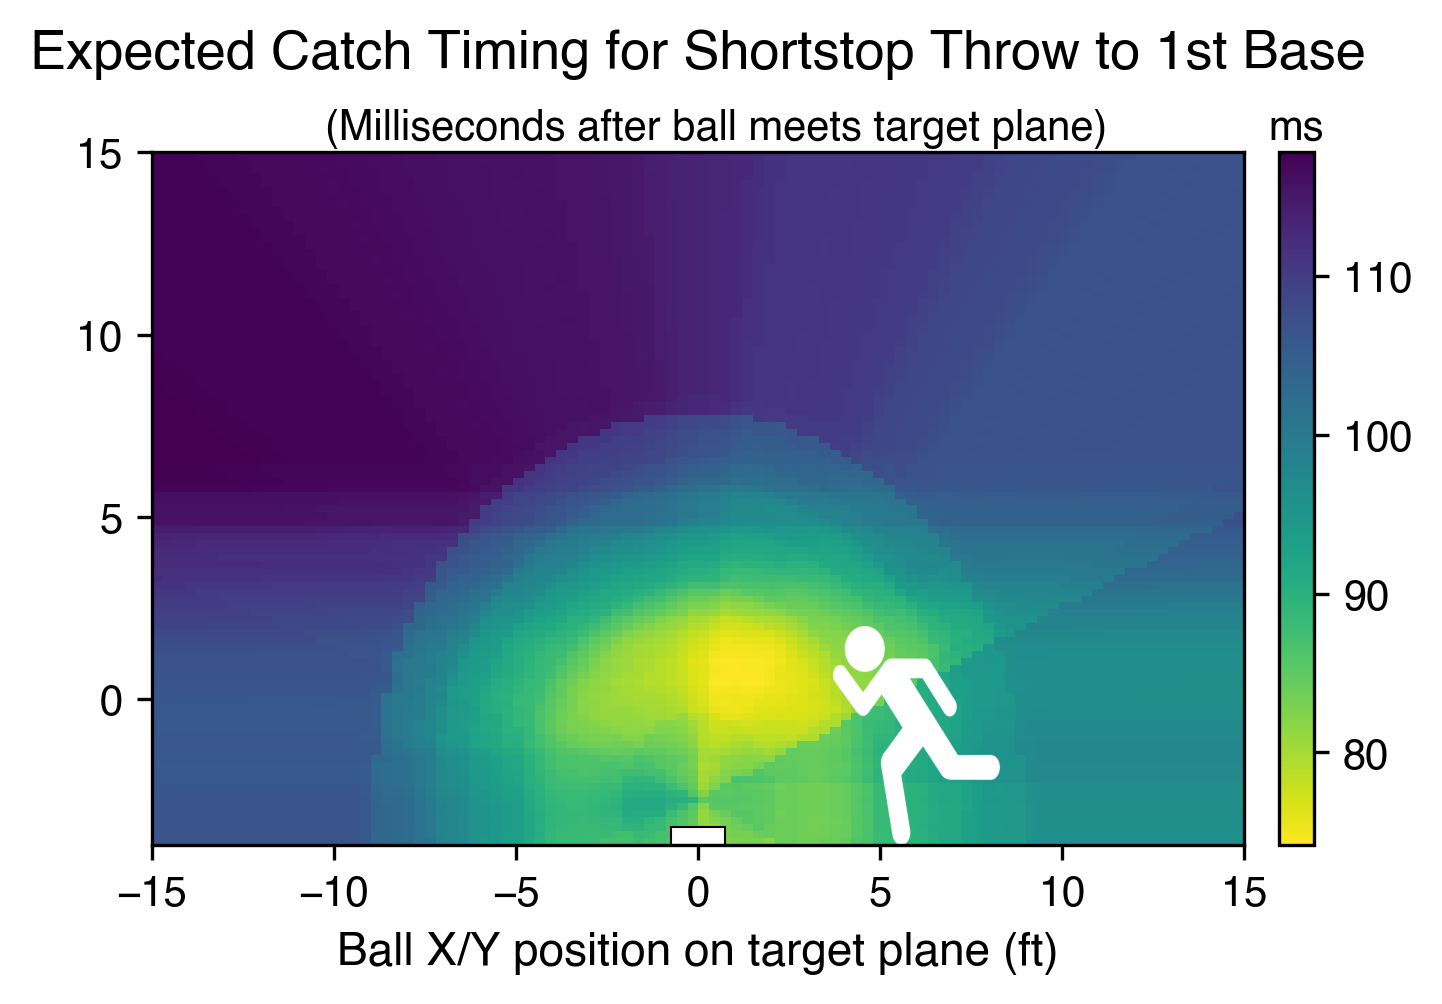

In [68]:
"""
Fit ML model for catch timestamp at intersection
    (Filter for CatchOn)
    1. Filter for CatchOn
    2. Get X, y
    3. Split X, y into train/val/test
    4. Create prep data structures
    5. Train CatBoost
    6. Create ensemble (Bagging)
    7. Evaluate model
    8. Visualize
"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
sampler = optuna.samplers.TPESampler(seed=SEED)

## 1. Filter for CatchOn
prep_ds_1 = prep_ds[prep_ds['target']==0]
prep_ds_1 = prep_ds_1.dropna(subset=['itsx_catch_ts_delta'])

## 2. Get X, y
X = prep_ds_1[['plane_orientation_polar','plane_orientation_azimuth',
               'ball_norm_x_plane','proj_ball_z','ball_dis_plane_origin',
               'ball_direction_polar','ball_direction_azimuth','E_ft_til_1st_itsx']].astype(np.float32)
y = prep_ds_1['itsx_catch_ts_delta'].astype(np.float32)

## 3. Split X, y into train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=SEED)

## 4. Create prep data structures
# Catboost Pool
train_pool = cat.Pool(X_train, label=y_train)
val_pool = cat.Pool(X_val, label=y_val)
test_pool = cat.Pool(X_test, label=y_test)

## 5. Train CatBoost
OPTUNA_NTRIALS_CAT = 100
print("Starting optuna CatBoost study...")
ts_cat_models = []
def objective_cat(trial: optuna.Trial):
    params = {  "loss_function": "RMSE",
                # "task_type": "GPU", 
                "depth": trial.suggest_int("depth", 2, 10),
                # "max_leaves": trial.suggest_int("max_leaves", 1, 20),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
                "iterations": 1000,  # num_boost_round
                "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100, log=True),
                "random_strength": trial.suggest_int("random_strength", 1, 20, log=True),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 500, log=True),
                "verbose": False,
                "random_seed": SEED   }
    model = cat.CatBoostRegressor(**params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=10,
        use_best_model=True,
        verbose=0)
    ts_cat_models.append(model)
    y_pred = model.predict(test_pool)
    return mean_squared_error(y_pred, test_pool.get_label())
# CatBoost study
cat_study = optuna.create_study(direction="minimize", sampler=sampler)
cat_study.optimize(objective_cat, n_trials=OPTUNA_NTRIALS_CAT)
# Save models
for i in range(OPTUNA_NTRIALS_CAT):
    ts_cat_models[i].save_model(f'../Models/catch_timestamp_models/catch_timestamp_model_catboost_{i}')

## 6. Bagging
# (Ensemble; Average the predictions)
from Helpers import Ensemble
cat_ensemble = Ensemble(ts_cat_models)

## 7. Evaluate model
# Train naive model for comparison
naive_params = {"loss_function": "RMSE",
                "depth": 2,
                "learning_rate": 1,
                "iterations": 100,
                "verbose": False,
                "random_seed": SEED   }
naive_cat = cat.CatBoostRegressor(**naive_params)
naive_cat.fit(train_pool)
# Predictions
pred_train_naive = naive_cat.predict(X_train)
pred_train_ensemble = cat_ensemble.predict(X_train)
pred_test_naive = naive_cat.predict(X_test)
pred_test_ensemble = cat_ensemble.predict(X_test)
# Compare loss 
print("On train data:")
print("CatBoost (Naive) RMSE:              ", mean_squared_error(y_train, pred_train_naive))
print("CatBoost (Tuning + Bagging) RMSE:   ", mean_squared_error(y_train, pred_train_ensemble))
print("CatBoost (Naive) R²:                ", r2_score(y_train, pred_train_naive))
print("CatBoost (Tuning + Bagging) R²:     ", r2_score(y_train, pred_train_ensemble))
print("\n")
print("On test data:")
print("CatBoost (Naive) RMSE:              ", mean_squared_error(y_test, pred_test_naive))
print("CatBoost (Tuning + Bagging) RMSE:   ", mean_squared_error(y_test, pred_test_ensemble))
print("CatBoost (Naive) R²:                ", r2_score(y_test, pred_test_naive))
print("CatBoost (Tuning + Bagging) R²:     ", r2_score(y_test, pred_test_ensemble))
# Feature importance
fi = [model.get_feature_importance() for model in ts_cat_models]
mean_fi = np.mean(fi, axis=0)
print("Features: ", ts_cat_models[0].feature_names_)
print("Mean feature importance: ", mean_fi)

## 8. Visualize
import matplotlib.image as mpimg
import matplotlib.patches as patches
# (Copy & Paste from above; same thing)
x = np.linspace(-15,15,100)
y = np.linspace(-1,15,100)
ball_pos_x_plane,ball_pos_y_plane = np.meshgrid(x,y)
# Create sample data
test_df = pd.DataFrame({
        'plane_orientation_polar': 155,
        'plane_orientation_azimuth': 8,
        'ball_pos_x_plane': ball_pos_x_plane.flatten(),
        'ball_pos_y_plane': ball_pos_y_plane.flatten(),
        'ball_direction_polar': -25,
        'ball_direction_azimuth': -14,
        'proj_ball_z': ball_pos_y_plane.flatten()+1,
        'E_ft_til_1st_itsx': 6 })
test_df['ball_dis_plane_origin'] = np.sqrt(test_df['ball_pos_x_plane']**2 + test_df['ball_pos_y_plane']**2)
test_df['ball_norm_x_plane'] = test_df['ball_pos_x_plane']/test_df['ball_dis_plane_origin']
test_df['ball_norm_y_plane'] = test_df['ball_pos_y_plane']/test_df['ball_dis_plane_origin']
# Save ball_pos_x/y for later visualization
saved = test_df[['ball_pos_x_plane','ball_pos_y_plane']].copy()
test_df = test_df[['plane_orientation_polar','plane_orientation_azimuth','ball_norm_x_plane','proj_ball_z','ball_dis_plane_origin','ball_direction_polar','ball_direction_azimuth','E_ft_til_1st_itsx']]
# Create predictions
test_y_pred_ensemble = cat_ensemble.predict(test_df)
test_df['pred_time_delta'] = test_y_pred_ensemble
# Bring back ball_pos_x/y
test_df = pd.concat([test_df, saved], axis=1)
# Plot
plt.figure(figsize=(5,3), dpi=300)
grid = test_df[['ball_pos_x_plane','ball_pos_y_plane','pred_time_delta']].pivot(index='ball_pos_y_plane',columns='ball_pos_x_plane',values='pred_time_delta')
plt.xticks(np.arange(-15, 16, 5))
plt.yticks(np.arange(0, 16, 5))
plt.xlabel("Ball X/Y position on target plane (ft)", fontsize=11)
plt.imshow(stickman, extent=[3.5, 8.5, -4, 2],zorder=2)
im = plt.imshow(grid, aspect='auto', extent=[-15, 15, -4, 15], origin='lower', cmap='viridis_r')
plt.gca().add_patch(patches.Rectangle((-0.75,-4), width=1.5,height=0.5,facecolor='white',zorder=2,edgecolor='black',lw=0.5))
plt.colorbar(im, orientation='vertical', fraction=0.03, pad=0.03)
plt.title("Expected Catch Timing for Shortstop Throw to 1st Base", fontsize=13, pad=20)
plt.text(0.5, 16.2, "(Milliseconds after ball meets target plane)", ha='center', va='top', fontsize=10)
plt.text(16.43, 16.2, "ms", ha='center', va='top', fontsize=10)
plt.show()